In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

#%matplotlib inline

train = pd.read_csv('https://drive.google.com/uc?id=1wRHYjjkYjwNvatPc_SuXpfjmwuEIibM8')
test = pd.read_csv('https://drive.google.com/uc?id=1wfSmllbBVObXAq5qAprHkvLJ-OsXUYiL')
submission = pd.read_csv('https://drive.google.com/uc?id=1Q7c0ZEiLVCWWsC6IYsMZJAb8UzGcnywa')
items = pd.read_csv('https://drive.google.com/uc?id=1onY4heRR3zv4uC9oHbk-mSvYzIX5N6_S')
item_cats = pd.read_csv('https://drive.google.com/uc?id=1nMqGd_rJe-r1EDoDYP_I67gnXkNPSEAt')
shops = pd.read_csv('https://drive.google.com/uc?id=1OOs15aLwHhLWo9gAp3BsFmR8_mnTlDR2')

In [0]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [0]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

**Alguns insights dos dados**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


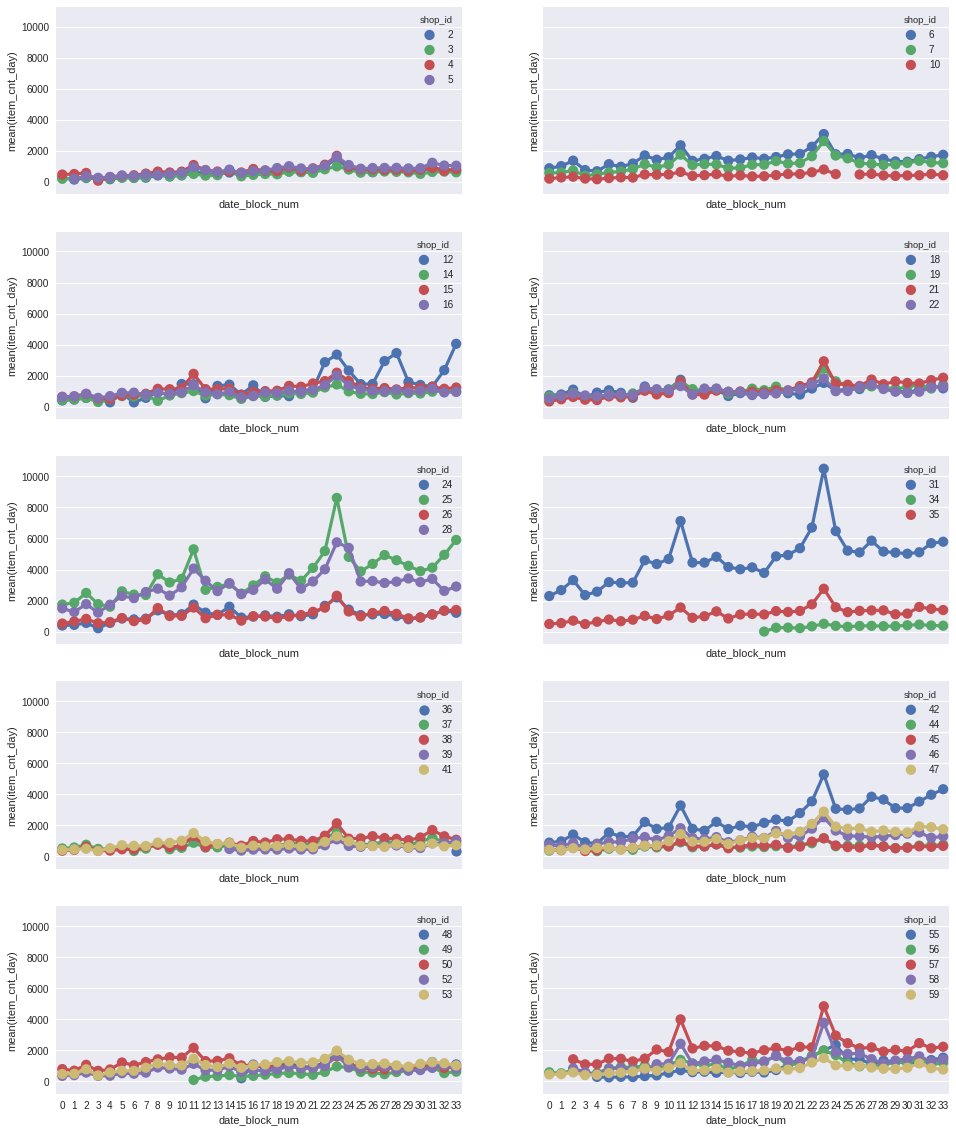

In [6]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

**Adicionando categorias**

In [0]:
# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [0]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


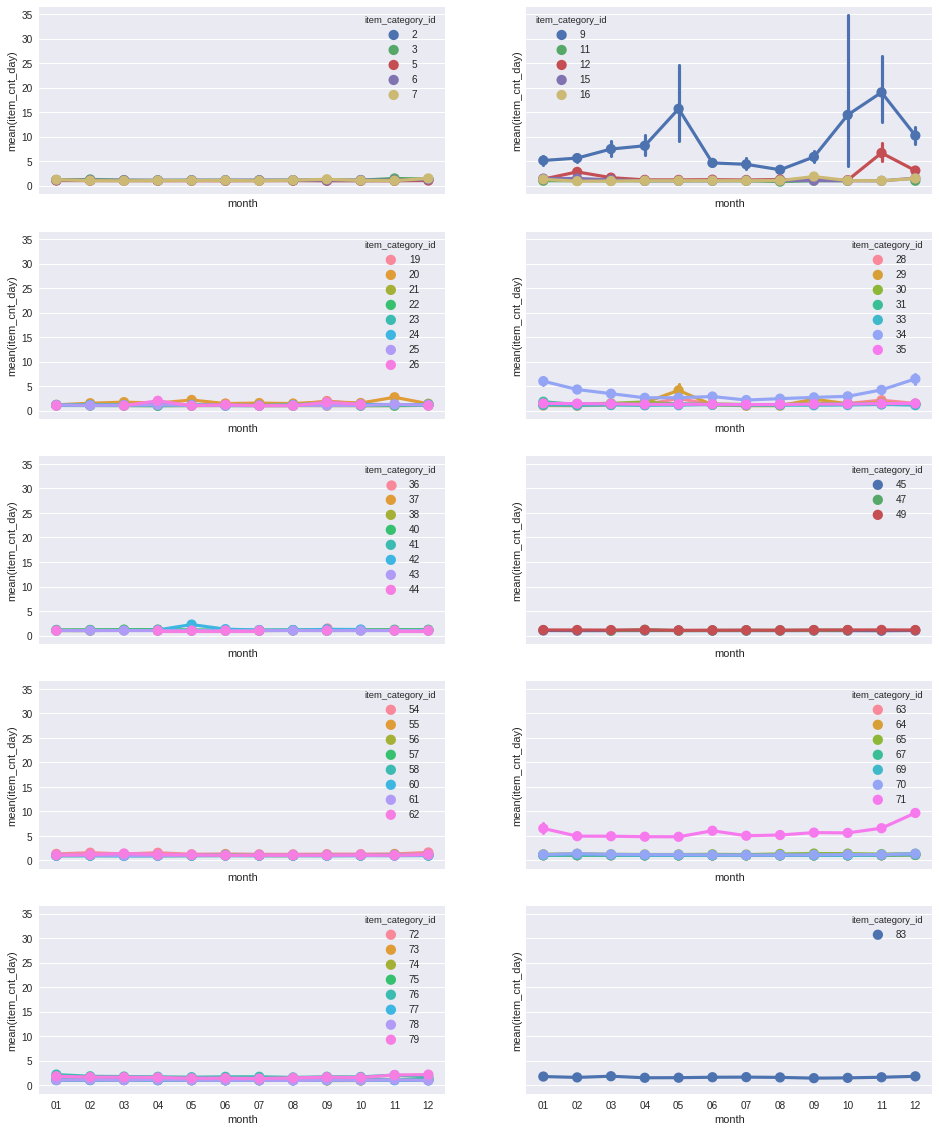

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


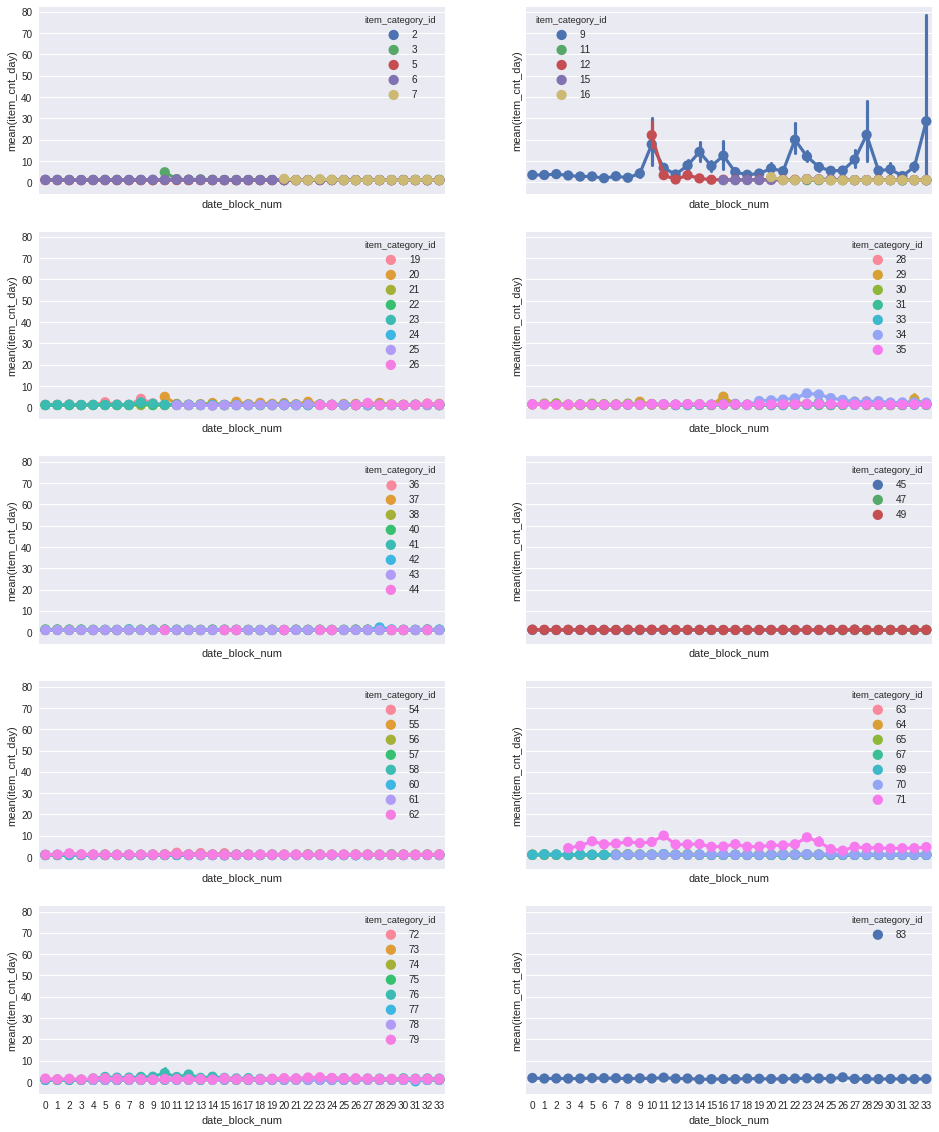

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [0]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

**Treinamento**

In [0]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

Nem todo item vendi está no período de tempo acima, vamos adicionar um registro para eles com item_cnt_day como 0. O preço é um pouco complicado. Como pode ser visto no código abaixo, o preço de um item depende da loja e do ponto do tempo. Vamos preencher os valores vazios com o registro passado mais próximo.

In [13]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.072265      0.115543
                       4          0.041532      0.381274
                       5         -0.072265      0.204120
                       6          0.314142      2.241392
                       7          0.149626      0.647005
                       10        -0.186490      0.115543
                       12        -0.242961     -0.150189
                       14         0.149626      0.469851
                       15         0.208426      1.178467
                       16         0.097005      1.178467
                       18        -0.072265      0.292697
                       19         0.152478      1.089890
                       21         0.098431      0.912736
                       22         0.041532      0.558428
                       24         0.326026      1.089890
                       25         0.439823      4.012933
                       26         0.316329      1.709929
                       28         0.661704      4.987280
                       31         0.665965      9.681864
                       35         0.142971      1.178467
                       37         0.212228      1.089890
                       38         0.098431      0.469851
                       41        -0.186062     -0.061612
                       42         0.548283      3.835779
                       44         0.269127      1.355621
                       45        -0.015366      0.292697
                       46         0.382925      1.621352
                       47         0.089854      0.647005
                       50         0.494821      2.329969
                       52        -0.129164      0.204120
...                                    ...           ...
22167   30             52        -0.214583     -0.061612
        31             2         -0.257221     -0.150189
                       12        -0.129306      0.115543
                       22         0.041247      0.912736
                       25        -0.214583     -0.061612
                       26        -0.257221     -0.150189
                       31        -0.257221     -0.150189
                       35        -0.257221     -0.150189
                       39        -0.257221     -0.150189
                       42        -0.171945      0.026965
                       52        -0.214583     -0.061612
        32             12        -0.044030      0.292697
                       21        -0.214583     -0.061612
                       22        -0.129306      0.115543
                       24        -0.257221     -0.150189
                       25        -0.129306      0.115543
                       42        -0.171945      0.115543
        33             6         -0.257221     -0.150189
                       10        -0.277756     -0.150189
                       12        -0.001391      0.381274
                       18        -0.257221     -0.150189
                       21        -0.257221     -0.150189
                       22         0.162767      1.001313
                       25        -0.214583      0.026965
                       26        -0.257221     -0.150189
                       28        -0.257221     -0.150189
                       37        -0.257221     -0.150189
                       42        -0.171945      0.115543
                       47        -0.257221     -0.150189
                       50        -0.257221     -0.150189

[600159 rows x 2 columns]

A fim de facilitar o agrupamento

In [0]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

Alguns funções "helpers"

In [0]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [0]:
assert closest_date_block(18, 30, 5) == 18

In [17]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


In [0]:
Vamos fazer algumas contas simples para descobrir em qual bloco devemos treinar

In [0]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [4]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

NameError: ignored

In [0]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

Em seguida, transformaríamos o valor categórico em sua versão de codificação única

In [0]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

In [0]:
def vectorize(inp):
    print('Vectorization...')   
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [3]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

NameError: ignored

In [0]:
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

A aprendizagem parece convergir. Vamos incrementar algunas coisas no treino em relação ao conjunto de validação

In [0]:
model.fit(x_val, y_val, batch_size=128, epochs=13)

## **Infer**ência

In [0]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)